<a href="https://colab.research.google.com/github/snjugunanjenga/google-devs-python-machine-learning/blob/main/MIT_Lecture_10_Finetuning_with_LORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CREDIT:** Adapted from this [notebook](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb).


##### Copyright 2024 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

This notebook walks you through using Keras to perform LoRA fine-tuning on a Google Gemma 2B model using an instruction-answer dataset.

## Setup

### Get access to Gemma and set up your API keys

The instructions are below (if you run into issues, you can refer to the detailed instructions [here](https://ai.google.dev/gemma/docs/setup)).


* Go to [kaggle.com](https://kaggle.com) and create an account.
* Go to the [Gemma model card](https://www.kaggle.com/models/google/gemma) and select **Request Access**. Complete the consent form and accept the terms and conditions.
* Go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your Kaggle username and Kaggle API key.
* Open this file using a text editor.
* In Colab, select **Secrets** (🔑) in the left pane.  
- Copy your Kaggle username from the text editor and store it under the name `KAGGLE_USERNAME`.  
- Copy your Kaggle API key from the text editor and store it under the name `KAGGLE_KEY`.

When you are done, it should look like this:



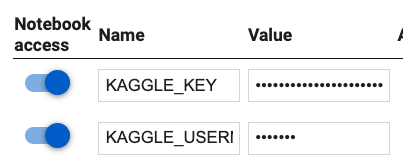

### Select the runtime

To run this notebook, you'll need a T4 GPU.

1. In the upper-right of the Colab window, select the down arrow.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [2]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

SecretNotFoundError: Secret KAGGLE_USERNAME does not exist.

In [ ]:
from pprint import pprint

### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

### Select a backend

Keras 3 is the latest version of Keras and with it you can run workflows on one of three backends: TensorFlow, JAX, or PyTorch.

For this tutorial, we will use JAX.

In [ ]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [ ]:
import keras
import keras_nlp

## Load Dataset

We will use the [Databricks Dolly 15k dataset](https://huggingface.co/datasets/databricks/databricks-dolly-15k). This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

In [ ]:
!wget -O databricks-dolly-15k.jsonl https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl

Let's read the file into a dataframe and take a look at a few examples.

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
df = pd.read_json("databricks-dolly-15k.jsonl", lines=True)

In [ ]:
df.sample(5)

Every example has an `instruction`, a `response` and a `category`. Some examples also have a `context`.

We will fine-tune using only those examples that don't have a `context`; we will also ignore `category` since we want to do text generation, not classification.

Finally, we will grab a subset of just 1000 training examples to execute the notebook faster. Feel free to re-run the notebook later with more training data for higher quality fine-tuning.

Here's some code to do the above.

In [ ]:
import json
data = []
with open("databricks-dolly-15k.jsonl") as file:
    for line in file:
        features = json.loads(line)
        # Filter out examples with context, to keep it simple.
        if features["context"]:
            continue
        # Format the entire example as a single string.
        template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        data.append(template.format(**features))

# Only use 1000 training examples, to keep it fast.
data = data[:1000]

Let's take a look at a few random examples.

In [ ]:
import random
for d in random.sample(data, 3):
  print(d, "\n", 50*"=", "\n")

## Load Model

KerasNLP provides access to many [pretrained models](https://keras.io/api/keras_nlp/models/). Let's take a quick look.

In this notebook, we'll fine-tune a 2-billion-parameter base [Gemma LLM ](https://blog.google/technology/developers/gemma-open-models/). Note that this model is a **base** LLM. It has **not** been instruction tuned.

We first download the model using the `from_preset` method.

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Looks like the LLM has
- a vocab size of 256,000 tokens
- uses embeddings of size 2048

## Inference before fine tuning

Let's query the model with various prompts to see how it responds.


### Europe Trip Prompt

We will prompt the model for suggestions on what to do on a trip to Europe.

Let's build the prompt.

In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)

print(prompt)

Note that the prompt has an "Instruction - Response" format but because the base LLM hasn't been instruction tuned, it is not clear that it will actually "understand" this format and use it appropriately in its response.

We will use [Top-K sampling](https://keras.io/api/keras_nlp/samplers/top_k_sampler/) (with K=5) and ask the model to stop  after it has generated 256 tokens.

In [ ]:
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

The model responds with generic tips on how to plan a trip. Furthermore, it has listed some questions and responses to those questions. The answer is not coherent and not all that helpful.

### ELI5 Photosynthesis Prompt

Next, let's prompt the model to explain photosynthesis in terms simple enough for a 5 year old child to understand.


In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

The model has generated a list of multiple Instruction-Response pairs rather than a single, easy-to-understand response to the original question.

## LoRA Fine-tuning

To get better responses from the model, we will instruction-fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank parameter referred to below is the length of the narrow dimension of the "long and narrow" matrices we saw in class.

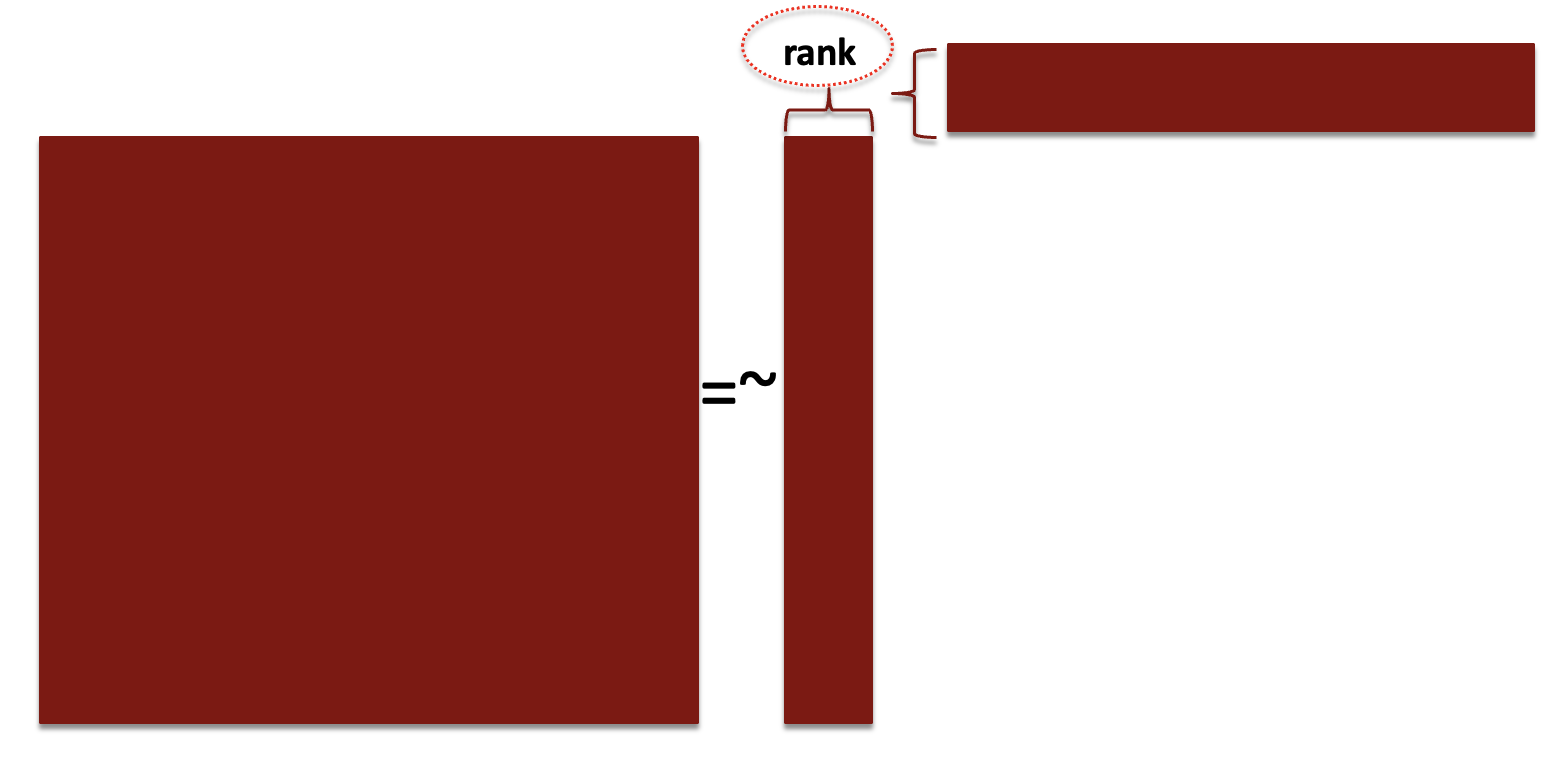

A higher rank means more detailed changes are allowed, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.5 billion to 1.3 million).

We will now train the model using the familiar `compile` and `fit` functions provided by Keras.

Instead of using the `Adam` optimizer, we will use `AdamW` which is commonly used for training Transformer-based models (feel free to try fine-tuning with `Adam` if you are curious).

In [ ]:
# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 512


# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])
# if you use Adam instead of AdamW, comment out the line above


gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# we will make just one pass through the data
# and each batch will just be one example

gemma_lm.fit(data, epochs=1, batch_size=1)

This took 22 minutes for me!!

## Inference after fine-tuning

Let's see if instruction-fine-tuning helped adapt the base LLM.

### Europe Trip Prompt


Let's try the Europe trip prompt again.

In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
pprint(gemma_lm.generate(prompt, max_length=256))

The output is definitely more coherent than before and it adheres nicely to the Instruction/Response format of the fine-tuning data. 👍

### ELI5 Photosynthesis Prompt


Let's try the "explain like I am 5" (ELI5) prompt again.

In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
pprint(gemma_lm.generate(prompt, max_length=256))

As with the Europe prompt, the output is definitely better!



---


Recall that we fine-tuned using only 1000 instruction-response pairs and with a LORA rank of just 4.

To get better responses from the fine-tuned model, you can experiment with:

1. Increasing the size of the fine-tuning dataset
2. Training for more steps (epochs)
3. Setting a higher LoRA rank

Or you can bring in **your** own Instruction-Response dataset and fine-tune Gemma on it.

Happy Fine-Tuning!! 🚀